# Bertic, ternary CLF, on full train

In [7]:
label_set = ['Negative', 'Neutral', 'Positive']
STR_TO_NUM = {k: i for i, k in enumerate(label_set)}
NUM_TO_STR = {i:k for i, k in enumerate(label_set)}

import pandas as pd
df = pd.read_json("bcs_polsent_007.jsonl", orient="records", lines=True)
df["label"] = df.label.apply(lambda s: STR_TO_NUM[s])
df = df[["sentence", "label", "split"]].rename(columns={"sentence": "text", "label":"labels"})
train = df[df.split=="train"].drop(columns=["split"]).reset_index(drop=True)
dev = df[df.split=="dev"].drop(columns=["split"]).reset_index(drop=True)
test = df[df.split=="test"].drop(columns=["split"]).reset_index(drop=True)

In [14]:
df = pd.read_json("bcs_polsent_007.jsonl", orient="records", lines=True)


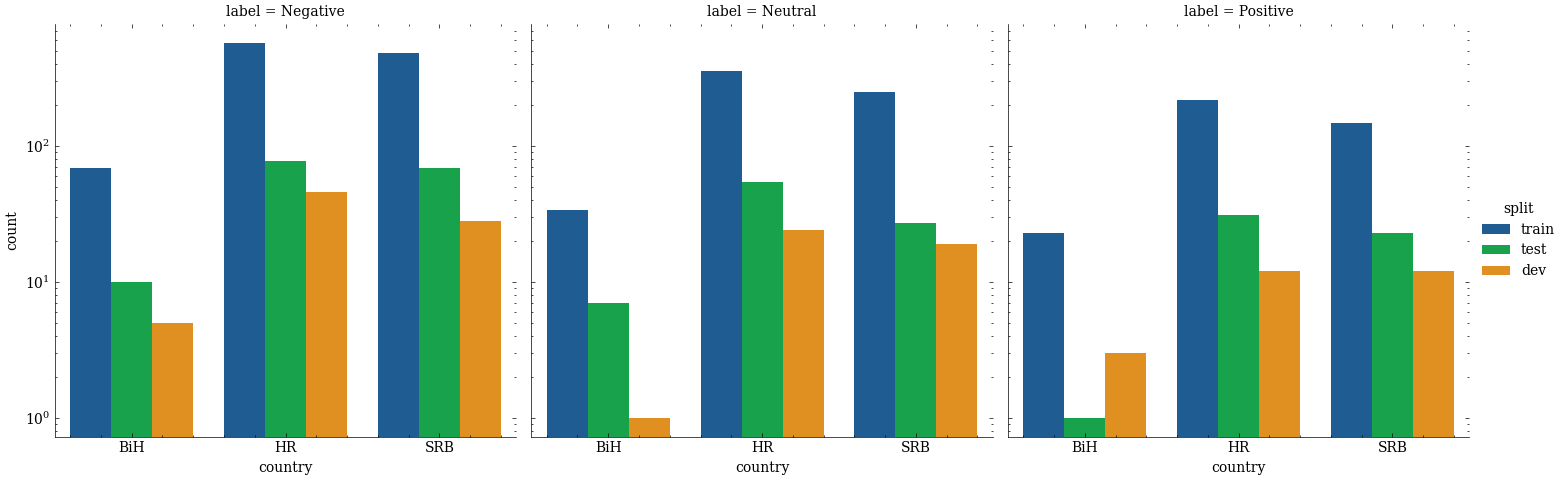

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex'])



catplot = sns.catplot(x="country", kind="count", hue="split", data=df, col="label", col_order=["Negative", "Neutral", "Positive"])

catplot.axes[0][0].set_yscale("log")

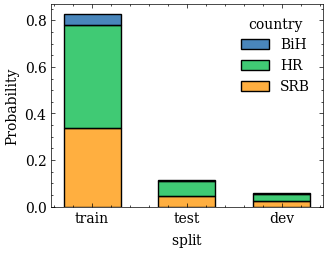

AttributeError: 'Rectangle' object has no property 'multiple'

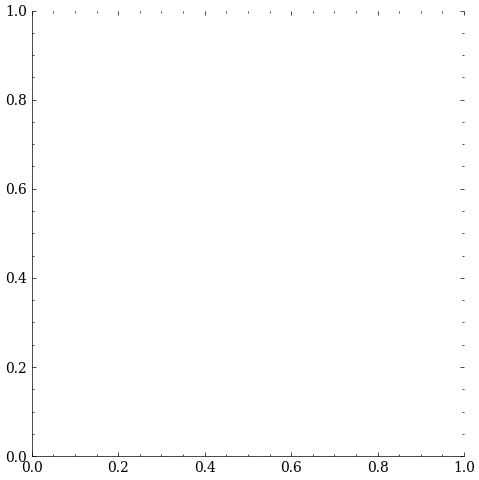

In [84]:
plt.style.use(["science", "no-latex"])
fig, ax = plt.subplots()
# ax.set_yscale("log")
sns.histplot(
    df,
    stat="probability",
    x="split",
    hue="country",
    multiple="stack",
    ax=ax,
    hue_order="BiH HR SRB".split(),
    shrink=0.6,
    # palette="Oranges",

)
ax.set_xlabel(r"$\mathrm{split}$")
plt.show()

sns.catplot(kind="count", x="split", hue="country", data=df)
plt.show()


In [2]:
def train_model(train_df, model_name, output_dir):
    if model_name == "EMBEDDIA/crosloengual-bert":
        model_type = "bert"
        NUM_EPOCH = 3
    elif model_name == "classla/bcms-bertic":
        model_type = "electra"
        NUM_EPOCH = 9
    elif model_name == "xlm-roberta-base":
        model_type = "xlmroberta"
        NUM_EPOCH = 40
    else:
        raise AttributeError(f"Expected either xlm-roberta-base, classla/bcms-bertic, or EMBEDDIA/crosloengual-bert, got {model_name}.")

    from simpletransformers.classification import ClassificationModel
    import torch
    torch.cuda.empty_cache()
    model_args = {
        "num_train_epochs": NUM_EPOCH,
        "learning_rate": 4e-5,
        "overwrite_output_dir": True,
        "train_batch_size": 8, 
        # "no_cache": True,
        "output_dir": output_dir,
        #"save_steps": -1,
        "max_seq_length": 512,
        "silent": True,
    }

    model = ClassificationModel(
        model_type, model_name, num_labels=3, use_cuda=True, args=model_args
    )
    model.train_model(train_df)
    return model


def eval_model(model, test_df):
    y_true_enc = test_df.labels
    from tqdm.auto import tqdm
    y_pred_enc = [model.predict(i)[0][0] for i in tqdm(test_df.text.values)]

    y_true = [NUM_TO_STR[i] for i in y_true_enc]
    y_pred = [NUM_TO_STR[i] for i in y_pred_enc]
    from sklearn.metrics import f1_score
    macroF1 = f1_score(y_true, y_pred, labels=label_set, average="macro")

    return {"macroF1": macroF1, "y_true": y_true, "y_pred": y_pred}


In [3]:
model = train_model(train, "classla/bcms-bertic", "models/ternary")
eval_model(model, test)["macroF1"]

Some weights of the model checkpoint at classla/bcms-bertic were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at classla/bcms-bertic and are newly initialized: ['pooler.dense.weight', 'classifier.bias',